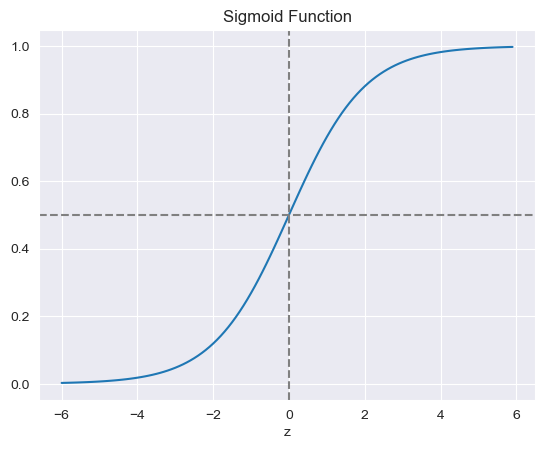

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 시그모이드 정의
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.arange(-6, 6, 0.1)
p = sigmoid(z)

(pd.DataFrame({'z': z, 'p': p})
 .plot(x='z', y='p', legend=False, title='Sigmoid Function'))
plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--')
plt.show()

### 2. 데이터 불러오기 & 기본 전처리
*Churn_Modelling.csv
- 성별: LabelEncoder(남=0, 여=1)
- 지역: 원 - 핫
인코딩
- 불필요 / 문제
컬럼
제거
후 표준화(StandardScaler)

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 2-1) 데이터 로드
data = pd.read_csv('data/Churn_Modelling.csv')

# 2-2) 범주형 인코딩
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])      # 남 0, 여 1
data = pd.get_dummies(data, columns=['Geography'])     # 지역 원-핫

# 2-3) (선택) 로그 변환 예시
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 2-4) 학습에 쓰지 않을 컬럼 제거
drop_cols = ['RowNumber', 'CustomerId', 'Surname',    # 식별자
             'LogAge', 'LogBalance',                  # 이번엔 제외
             'Exited']                                # 목표값
X = data.drop(columns=drop_cols)
y = data['Exited']

# 2-5) 학습/테스트 분리 (비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 2-6) 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

### 3. 로지스틱 회귀 학습 & 평가

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 3-1) 모델 학습
lr_clf = LogisticRegression(max_iter=1000, solver='lbfgs')
lr_clf.fit(X_train, y_train)

# 3-2) 정확도
print("테스트 정확도:", lr_clf.score(X_test, y_test))

# 3-3) 혼동 행렬 & 리포트
y_pred = lr_clf.predict(X_test)
print("\n혼동 행렬")
print(confusion_matrix(y_test, y_pred))

print("\n분류 리포트")
print(classification_report(y_test, y_pred, target_names=['유지', '이탈']))

테스트 정확도: 0.808

혼동 행렬
[[1540   53]
 [ 331   76]]

분류 리포트
              precision    recall  f1-score   support

          유지       0.82      0.97      0.89      1593
          이탈       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



### 4. 회귀계수(β)와 절편, 결정함수 z, 예측 확률 p

In [4]:
# 4-1) 특성 이름 확보
feature_names = X.columns

# 4-2) 회귀계수 테이블
coef_df = (pd.Series(lr_clf.coef_[0], index=feature_names)
             .sort_values(key=abs, ascending=False)
             .to_frame('β'))
display(coef_df.head(10))   # 영향력이 큰 상위 10개

# 4-3) 테스트 샘플 3개로 z, p 직접 계산
sample = X_test[:3]
z = lr_clf.decision_function(sample)          # z 값
p = sigmoid(z)                                # 양성 확률
print("\n결정함수 z:", z)
print("양성(이탈) 확률 p:", p)
print("음성(유지) 확률 1−p:", 1 - p)

,β
Age,0.738899
IsActiveMember,-0.515396
Gender,-0.260854
Geography_Germany,0.244096
Balance,0.160344
Geography_France,-0.130455
Geography_Spain,-0.093632
CreditScore,-0.085973
NumOfProducts,-0.070560
EstimatedSalary,0.047749



결정함수 z: [-2.01041525 -0.94710531 -2.06599291]
양성(이탈) 확률 p: [0.11811372 0.27946734 0.11244633]
음성(유지) 확률 1−p: [0.88188628 0.72053266 0.88755367]


### 5. 모델 해석 간단 메모
* **양수 β** : 값이 커질수록 **이탈** 확률 ↑
* **음수 β** : 값이 커질수록 **이탈** 확률 ↓